Predict anomalies

✅ Confusion Matrix:
[[31  4]
 [ 1  1]]

📊 Classification Report:
              precision    recall  f1-score   support

           0      0.969     0.886     0.925        35
           1      0.200     0.500     0.286         2

    accuracy                          0.865        37
   macro avg      0.584     0.693     0.606        37
weighted avg      0.927     0.865     0.891        37



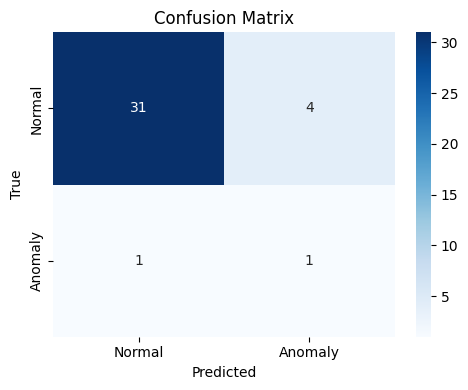


❌ False Positives: 4
         city  temperature  wind_speed  pressure  humidity
3   Engelberg         3.18      20.376    1016.0      0.41
5      Lugano         8.48      14.832    1014.0      0.45
15       Sion         7.25      29.628    1012.0      0.29
24       Sion         6.27      18.504    1013.0      0.33

❌ False Negatives: 1
    city  temperature  wind_speed  pressure  humidity
0  Aarau        666.0       3.204    1020.0      0.48


In [1]:
import pandas as pd
import joblib
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import os


# Daten laden und vorbereiten
def load_and_prepare_data(filepath: str) -> pd.DataFrame:
    df = pd.read_excel(filepath)
    df.columns = [
        "source",
        "date",
        "time",
        "city",
        "lat",
        "lon",
        "temperature",
        "wind_speed",
        "pressure",
        "humidity",
        "anomaly",
    ]

    df["humidity"] = (
        df["humidity"].astype(str).str.replace("%", "").str.strip().astype(float)
    )
    df["pressure"] = (
        df["pressure"]
        .astype(str)
        .str.replace("’", "")
        .str.replace("'", "")
        .str.strip()
        .astype(float)
    )
    df["anomaly"] = df["anomaly"].fillna(0).astype(int)
    return df


# Vorhersage mit geladenem Modell
def predict_anomalies(df: pd.DataFrame, model_dir: str):
    X = df[["temperature", "wind_speed", "pressure", "humidity", "lat", "lon"]]
    y_true = df["anomaly"]

    scaler = joblib.load(os.path.join(model_dir, "scaler.pkl"))
    model = joblib.load(os.path.join(model_dir, "isolation_forest_model.pkl"))

    X_scaled = scaler.transform(X)
    y_pred_raw = model.predict(X_scaled)
    y_pred = pd.Series(y_pred_raw).map({1: 0, -1: 1})

    df["predicted_anomaly"] = y_pred
    return y_true, y_pred, df


# Confusion Matrix & Report
def evaluate_predictions(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print("✅ Confusion Matrix:")
    print(cm)
    print("\n📊 Classification Report:")
    print(classification_report(y_true, y_pred, digits=3))

    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Normal", "Anomaly"],
        yticklabels=["Normal", "Anomaly"],
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()


# False Positives / Negatives anzeigen
def show_errors(df: pd.DataFrame, y_true, y_pred):
    false_positives = df[(y_true == 0) & (y_pred == 1)]
    false_negatives = df[(y_true == 1) & (y_pred == 0)]

    print(f"\n❌ False Positives: {len(false_positives)}")
    print(
        false_positives[["city", "temperature", "wind_speed", "pressure", "humidity"]]
    )

    print(f"\n❌ False Negatives: {len(false_negatives)}")
    print(
        false_negatives[["city", "temperature", "wind_speed", "pressure", "humidity"]]
    )


# Hauptausführung
if __name__ == "__main__":
    data_path = os.path.join("data", "anomalie.xlsx")
    model_dir = "model"

    df_test = load_and_prepare_data(data_path)
    y_true, y_pred, df_test = predict_anomalies(df_test, model_dir)
    evaluate_predictions(y_true, y_pred)
    show_errors(df_test, y_true, y_pred)

Modell-Visualisieren: Latent Space (2D-PCA oder t-SNE)

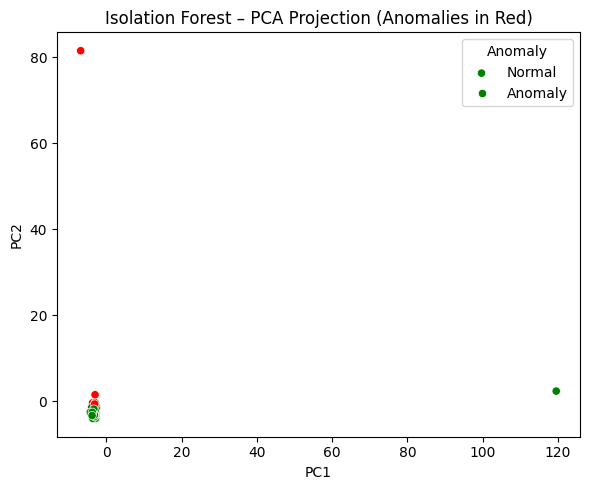

In [2]:
import pandas as pd
import joblib
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Datei- und Modellpfade
DATA_PATH = os.path.join("data", "anomalie.xlsx")
SCALER_PATH = os.path.join("model", "scaler.pkl")
MODEL_PATH = os.path.join("model", "isolation_forest_model.pkl")

# Excel-Datei laden & vorbereiten
df_test = pd.read_excel(DATA_PATH)
df_test.columns = [
    "source",
    "date",
    "time",
    "city",
    "lat",
    "lon",
    "temperature",
    "wind_speed",
    "pressure",
    "humidity",
    "anomaly",
]

df_test["humidity"] = (
    df_test["humidity"].astype(str).str.replace("%", "").str.strip().astype(float)
)
df_test["pressure"] = (
    df_test["pressure"]
    .astype(str)
    .str.replace("’", "")
    .str.replace("'", "")
    .str.strip()
    .astype(float)
)

# Features vorbereiten und transformieren
X_scaled = joblib.load(SCALER_PATH).transform(
    df_test[["temperature", "wind_speed", "pressure", "humidity", "lat", "lon"]]
)
y_pred_raw = joblib.load(MODEL_PATH).predict(X_scaled)

# Reduktion auf 2D (PCA)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualisierung
plt.figure(figsize=(6, 5))
sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1], hue=(y_pred_raw == -1), palette=["green", "red"]
)
plt.title("Isolation Forest – PCA Projection (Anomalies in Red)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Anomaly", labels=["Normal", "Anomaly"])
plt.tight_layout()
plt.show()

Modell-Visualisieren: Tree Strukturen im Forest anzeigen

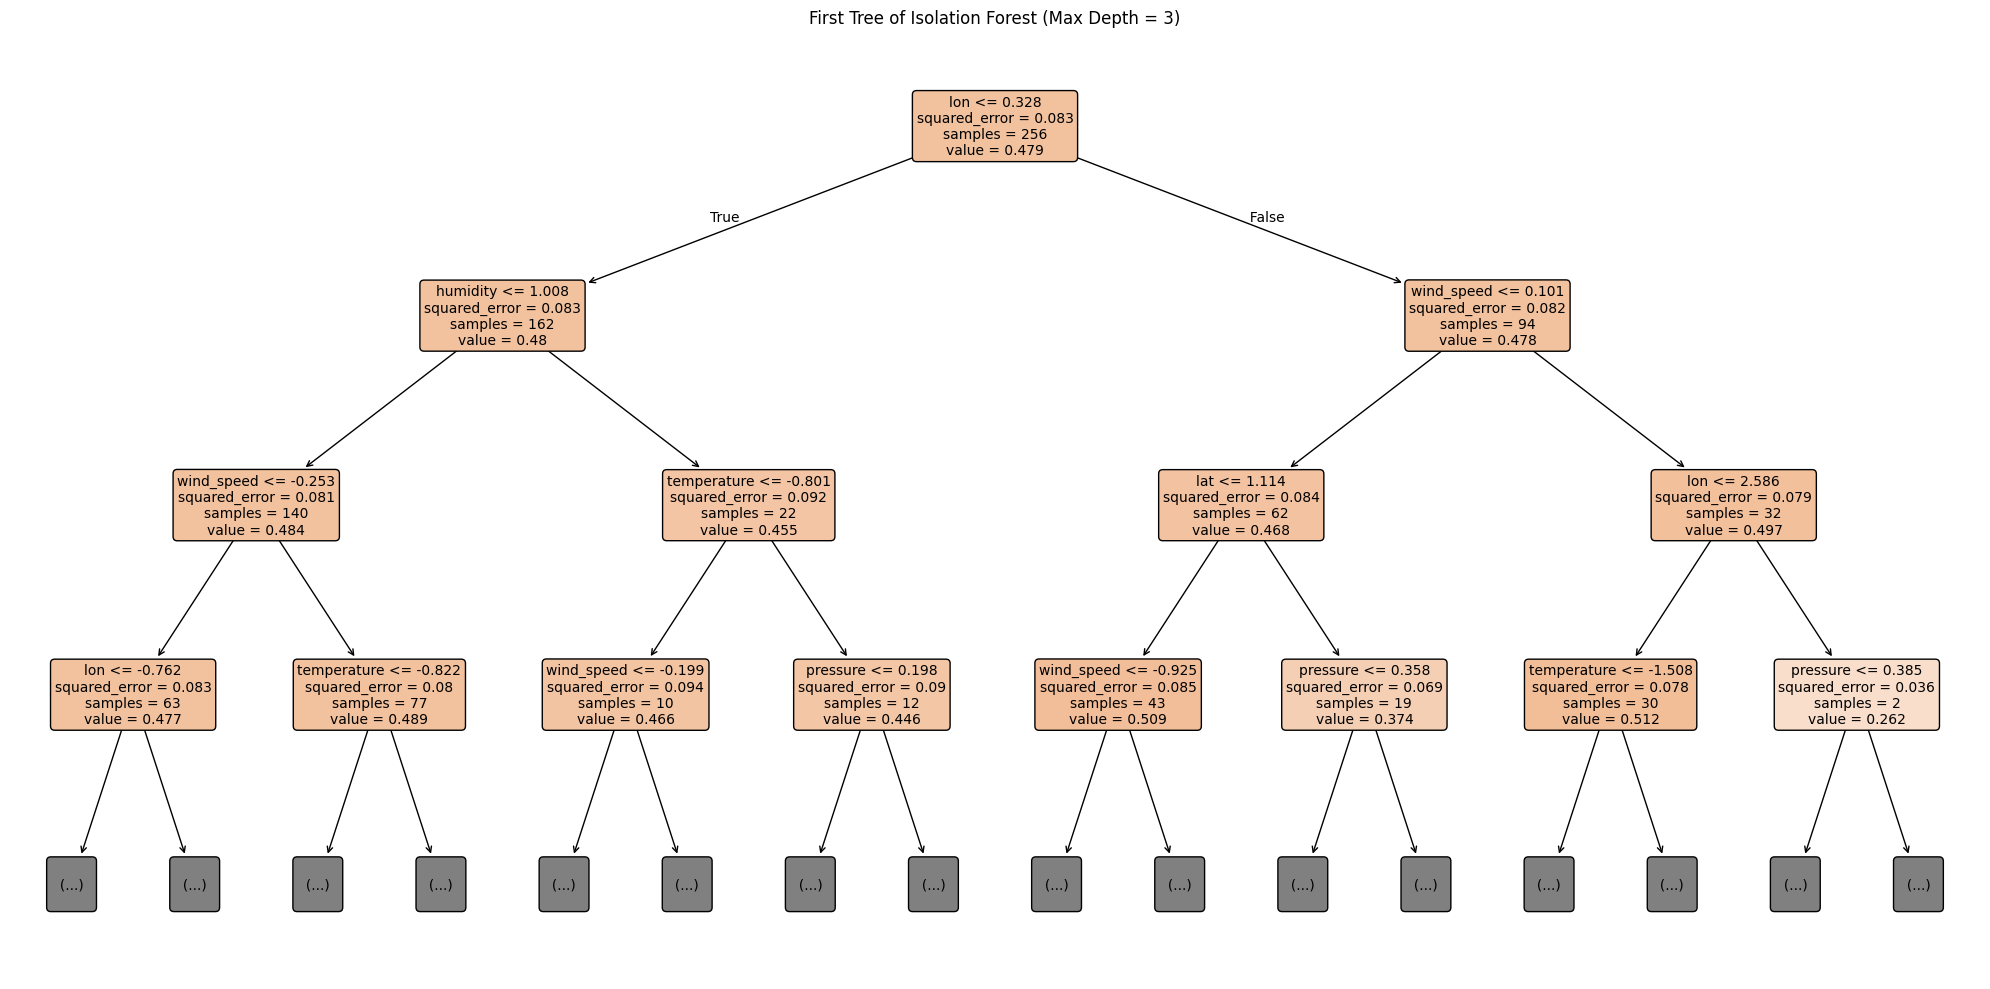

In [3]:
import joblib
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import os

# Modellpfad
MODEL_PATH = os.path.join("model", "isolation_forest_model.pkl")

# Modell laden & ersten Baum extrahieren
model = joblib.load(MODEL_PATH)
estimator = model.estimators_[0]  # erster Decision Tree im Ensemble

# Visualisierung
plt.figure(figsize=(20, 10))
plot_tree(
    estimator,
    max_depth=3,
    feature_names=["temperature", "wind_speed", "pressure", "humidity", "lat", "lon"],
    filled=True,
    rounded=True,
    fontsize=10,
)
plt.title("First Tree of Isolation Forest (Max Depth = 3)")
plt.tight_layout()
plt.show()